<a href="https://colab.research.google.com/github/leodenale/ColabExamples/blob/master/DSP_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to run GPU accelerated Signal Processing in TensorFlow](https://www.dlology.com/blog/how-to-run-gpu-accelerated-signal-processing-in-tensorflow/)

Original Article: https://www.dlology.com/blog/how-to-run-gpu-accelerated-signal-processing-in-tensorflow/

In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
print(tf.__version__)
import numpy as np

1.14.0


## Check eager execution is enabled

In [0]:
print(tf.executing_eagerly())        # => True

x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))  # => "hello, [[4.]]"

True
hello, [[4.]]


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!pip install -q librosa

In [0]:
!apt update -qq
!apt install -y -qq ffmpeg

47 packages can be upgraded. Run 'apt list --upgradable' to see them.
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.


In [0]:
!ffmpeg -version

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-

In [0]:
!wget -q https://github.com/Tony607/blog_statics/releases/download/v1.0/siren_mfcc_demo.wav

### Decode wav file

In [0]:
## Check the sampling rate of the WAV file.
audio_file = './siren_mfcc_demo.wav'


import wave
with wave.open(audio_file, "rb") as wave_file:
    sr = wave_file.getframerate()
print(sr)

44100


In [0]:
audio_binary = tf.read_file(audio_file)
# tf.contrib.ffmpeg not supported on Windows, refer to issue
# https://github.com/tensorflow/tensorflow/issues/8271
waveform = tf.contrib.ffmpeg.decode_audio(audio_binary, file_format='wav', samples_per_second=sr, channel_count=1)
print(waveform.numpy().shape)

W0701 15:26:51.854200 140171210930048 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0701 15:26:51.883381 140171210930048 deprecation.py:323] From <ipython-input-10-eb0b99dc59a3>:4: decode_audio (from tensorflow.contrib.ffmpeg.ffmpeg_ops) is deprecated and will be removed after 2018-09-04.
Instructions for updating:
tf.contrib.ffmpeg will be removed in 2.0, the support for video and audio will continue to be provided in tensorflow-io: https://github.com/tensorflow/io


(59904, 1)


In [0]:
# An alternative way to decode audio file.
# from scipy.io import wavfile
# sr, samples = wavfile.read(audio_file)
# samples = samples.reshape((1, -1))
# print(sr)
# print(samples.shape)

In [0]:
# Another alternative way to decode audio file.

# import librosa
# sound_clip,sr = librosa.load(audio_file)
# print("sampling rate:", sr)

# print(sound_clip.shape)
# signals = sound_clip.reshape((1, -1))
# print("signal shape: ", signals.shape)

In [0]:
signals = tf.reshape(waveform, [1, -1])
signals.get_shape()

TensorShape([Dimension(1), Dimension(59904)])

## Framing variable length sequences

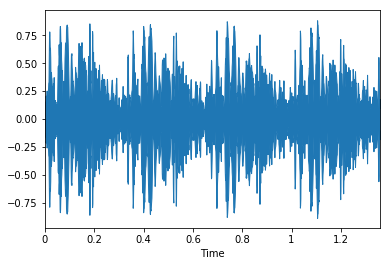

In [0]:
import librosa.display

librosa.display.waveplot(signals.numpy().flatten(),sr=sr)
plt.show()

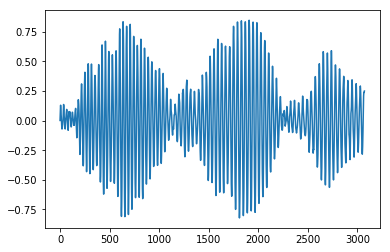

In [0]:
import matplotlib.pyplot as plt
plt.plot(waveform.numpy().flatten()[1024*2:1024*5])

In [0]:
# Compute a [batch_size, ?, 128] tensor of fixed length, overlapping windows
# where each window overlaps the previous by 75% (frame_length - frame_step
# samples of overlap).
frames = tf.contrib.signal.frame(signals, frame_length=128, frame_step=32)
print(frames.numpy().shape)

(1, 1869, 128)


In [0]:
# `magnitude_spectrograms` is a [batch_size, ?, 129] tensor of spectrograms. We
# would like to produce overlapping fixed-size spectrogram patches; for example,
# for use in a situation where a fixed size input is needed.
magnitude_spectrograms = tf.abs(tf.contrib.signal.stft(
    signals, frame_length=256, frame_step=64, fft_length=256))

print(magnitude_spectrograms.numpy().shape)

(1, 933, 129)


In [0]:
# `spectrogram_patches` is a [batch_size, ?, 64, 129] tensor containing a
# variable number of [64, 129] spectrogram patches per batch item.
spectrogram_patches = tf.contrib.signal.frame(
    magnitude_spectrograms, frame_length=64, frame_step=16, axis=1)

print(spectrogram_patches.numpy().shape)

(1, 55, 64, 129)


## Reconstructing framed sequences and applying a tapering window

In [0]:
# Reconstructs `signals` from `frames` produced in the above example. However,
# the magnitude of `reconstructed_signals` will be greater than `signals`.
reconstructed_signals = tf.contrib.signal.overlap_and_add(frames, frame_step=32)
print(reconstructed_signals.numpy().shape)

(1, 59904)


In [0]:
frame_length = 128
frame_step = 32
windowed_frames = frames * tf.contrib.signal.hann_window(frame_length)
print(windowed_frames.get_shape())

(1, 1869, 128)


In [0]:
reconstructed_signals = tf.contrib.signal.overlap_and_add(
    windowed_frames, frame_step)
reconstructed_signals.numpy().shape

(1, 59904)

## Computing spectrograms
 [Short-time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT)

In [0]:
# `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
# each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
# where fft_unique_bins = fft_length // 2 + 1 = 513.
stfts = tf.contrib.signal.stft(signals, frame_length=1024, frame_step=512,
                               fft_length=1024)

print(stfts.numpy().shape)

# array = stfts.numpy().astype(np.float)[0]
# plt.imshow(np.swapaxes(array,0,1))

(1, 116, 513)


In [0]:
# a complex number 
stfts.numpy()[0][0][0]

(3.6409717+0j)

### power_spectrograms

(1, 116, 513)


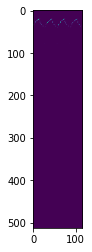

In [0]:
# A power spectrogram is the squared magnitude of the complex-valued STFT.
# A float32 Tensor of shape [batch_size, ?, 513].
power_spectrograms = tf.real(stfts * tf.conj(stfts))

print(power_spectrograms.numpy().shape)

array = power_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

### magnitude_spectrograms

(1, 116, 513)


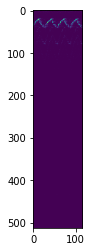

In [0]:
# An energy spectrogram is the magnitude of the complex-valued STFT.
# A float32 Tensor of shape [batch_size, ?, 513].
magnitude_spectrograms = tf.abs(stfts)

print(magnitude_spectrograms.numpy().shape)

array = magnitude_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

## Logarithmic compression

(1, 116, 513)


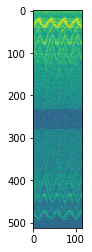

In [0]:
log_offset = 1e-6
log_magnitude_spectrograms = tf.log(magnitude_spectrograms + log_offset)
print(log_magnitude_spectrograms.numpy().shape)

array = log_magnitude_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

## Computing log-mel spectrograms
When working with spectral representations of audio, the [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a common reweighting of the frequency dimension, which results in a lower-dimensional and more perceptually-relevant representation of the audio.

(1, 116, 64)


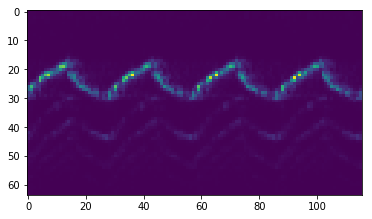

In [0]:
# Warp the linear-scale, magnitude spectrograms into the mel-scale.
num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000, 64

linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
    upper_edge_hertz)

mel_spectrograms = tf.tensordot(
    magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

print(mel_spectrograms.numpy().shape)

array = mel_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

In [0]:
mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))
mel_spectrograms.numpy().shape

(1, 116, 64)

If desired, compress the mel spectrogram magnitudes. For example, you may use logarithmic compression (as discussed in the previous section).

(1, 116, 64)


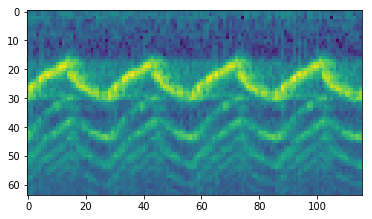

In [0]:
log_offset = 1e-6
log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

print(log_mel_spectrograms.numpy().shape)
array = log_mel_spectrograms.numpy()[0]
plt.imshow(np.swapaxes(array,0,1))

## Computing Mel-Frequency Cepstral Coefficients (MFCCs)

(1, 116, 30)


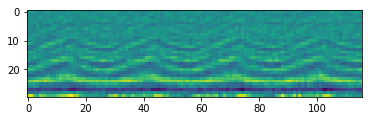

In [0]:
num_mfccs = 30
# Keep the first `num_mfccs` MFCCs.
mfccs = tf.contrib.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :num_mfccs]
print(mfccs.numpy().shape)
array = mfccs.numpy()[0]
plt.imshow(np.swapaxes(array,0,1)[::-1,:])

```signals->stfts->magnitude_spectrograms->mel_spectrograms->log_mel_spectrograms->mfccs```

In [0]:

def get_mfccs(audio_file=None ,signals=None, 
sample_rate = 44100, num_mfccs = 13, 
frame_length=1024, frame_step=512, 
fft_length=1024, fmax=8000, fmin=80):
    """Compute the MFCCs for audio file
    
    Keyword Arguments:
        audio_file {str} -- audio wav file path (default: {None})
        signals {tensor} -- input signals as tensor or np.array in float32 type (default: {None})
        sample_rate {int} -- sampling rate (default: {44100})
        num_mfccs {int} -- number of mfccs to keep (default: {13})
        frame_length {int} -- frame length to compute STFT (default: {1024})
        frame_step {int} -- frame step to compute STFT (default: {512})
        fft_length {int} -- FFT length to compute STFT (default: {1024})
        fmax {int} -- Top edge of the highest frequency band (default: {8000})
        fmin {int} -- Lower bound on the frequencies to be included in the mel spectrum (default: {80})
    
    Returns:
        Tensor -- mfccs as tf.Tensor
    """

    
    if signals is None and audio_file is not None:
      audio_binary = tf.read_file(audio_file)
      # tf.contrib.ffmpeg not supported on Windows, refer to issue
      # https://github.com/tensorflow/tensorflow/issues/8271
      waveform = tf.contrib.ffmpeg.decode_audio(audio_binary, 
          file_format='wav', samples_per_second=sample_rate, channel_count=1)
      signals = tf.reshape(waveform, [1, -1])
    
    # Step 1 : signals->stfts
    # `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
    # each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
    # where fft_unique_bins = fft_length // 2 + 1 = 513.
    stfts = tf.contrib.signal.stft(signals, frame_length=frame_length, frame_step=frame_step,
                                   fft_length=fft_length)
    # Step2 : stfts->magnitude_spectrograms
    # An energy spectrogram is the magnitude of the complex-valued STFT.
    # A float32 Tensor of shape [batch_size, ?, 513].
    magnitude_spectrograms = tf.abs(stfts)

    # Step 3 : magnitude_spectrograms->mel_spectrograms
    # Warp the linear-scale, magnitude spectrograms into the mel-scale.
    num_spectrogram_bins = magnitude_spectrograms.shape[-1].value

    num_mel_bins = 64

    linear_to_mel_weight_matrix = tf.contrib.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, fmin,
        fmax)

    mel_spectrograms = tf.tensordot(
        magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

    # Step 4 : mel_spectrograms->log_mel_spectrograms
    log_offset = 1e-6
    log_mel_spectrograms = tf.log(mel_spectrograms + log_offset)

    # Step 5 : log_mel_spectrograms->mfccs
    # Keep the first `num_mfccs` MFCCs.
    mfccs = tf.contrib.signal.mfccs_from_log_mel_spectrograms(
        log_mel_spectrograms)[..., :num_mfccs]
    
    return mfccs

mfccs shape (1, 116, 30)


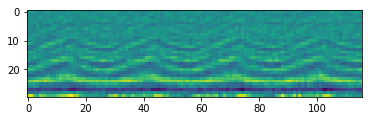

In [0]:
mfccs = get_mfccs(signals = signals, sample_rate=sr, num_mfccs = 30)

print("mfccs shape", mfccs.numpy().shape)
array = mfccs.numpy()[0]
plt.imshow(np.swapaxes(array,0,1)[::-1,:])

mfccs shape (1, 116, 30)


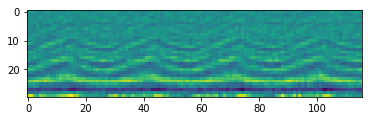

In [0]:
mfccs = get_mfccs(audio_file = audio_file, sample_rate=sr, num_mfccs = 30)

print("mfccs shape", mfccs.numpy().shape)
array = mfccs.numpy()[0]
plt.imshow(np.swapaxes(array,0,1)[::-1,:])